In [1]:
import os
import matplotlib
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

plt.style.use('seaborn')
pd.options.display.float_format = '{:,.0f}'.format
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False
if not any([s=='result' for s in os.listdir('.')]): os.mkdir('result')
if not any([s=='img' for s in os.listdir('.')]): os.mkdir('img')

In [2]:
사고이력_카카오_운영자 = pd.read_excel('입수파일/사고이력_120190625123.xlsx')
사고이력_카카오_이용자 = pd.read_excel('입수파일/사고이력_120191131774.xlsx')
익스포져_카카오 = pd.read_excel('입수파일/카카오_전기자전거_익스포져.xlsx')

#### Ⅰ. 익스포져

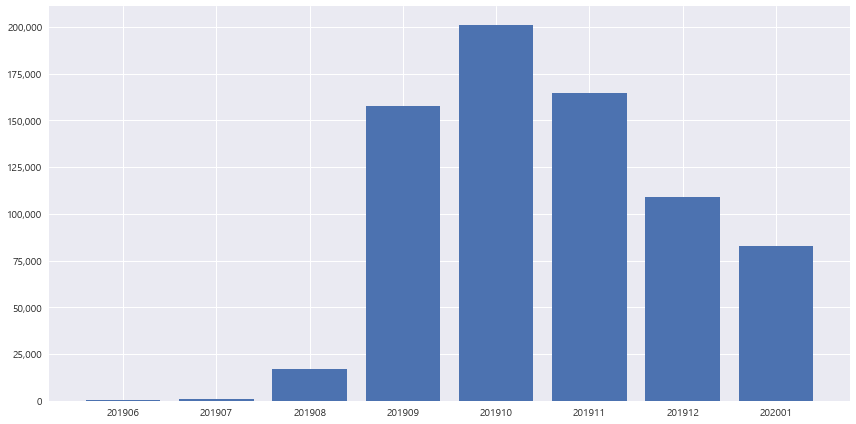

In [3]:
익스포져_카카오_가공 = 익스포져_카카오.copy()
익스포져_카카오_가공['기준년월'] = 익스포져_카카오_가공['기준년월'].astype(str)
익스포져_카카오_가공['운행건수'] = 익스포져_카카오_가공['운행건수'].astype(float)
익스포져_카카오_가공['경과일자'] = (익스포져_카카오_가공['종료일자'] - 익스포져_카카오_가공['시작일자']).apply(lambda x: x.days)

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(익스포져_카카오_가공['기준년월'], 익스포져_카카오_가공['운행건수'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.savefig('img/운행건수_월별.png')
plt.show()

#### Ⅱ. 사고건수(운영자)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(사고및면책_카카오_운영자['운행건수'], 사고및면책_카카오_운영자['사고건수'])
plt.tight_layout()
plt.savefig('img/운행건수_사고건수_카카오_운영자.png')
plt.show()

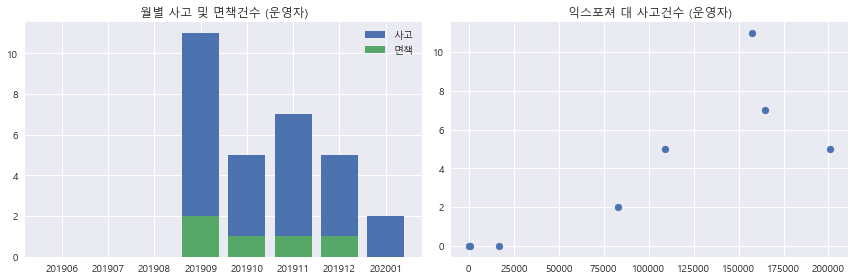

In [38]:
사고이력_카카오_운영자_가공 = 사고이력_카카오_운영자.copy()
사고이력_카카오_운영자_가공.eval('손해액 = 추산잔액+지급액+지급비용', inplace=True)
사고이력_카카오_운영자_가공['사고년월'] = 사고이력_카카오_운영자_가공['사고일'].apply(lambda x: str(x.year) + '{:02}'.format(x.month))
사고건수_카카오_운영자 = 사고이력_카카오_운영자_가공.groupby('사고년월').size().reset_index(name='사고건수')
면책건수_카카오_운영자 = 사고이력_카카오_운영자_가공.query('손해액 == 0').groupby('사고년월').size().reset_index(name='면책건수')
사고및면책_카카오_운영자 = 사고건수_카카오_운영자.merge(면책건수_카카오_운영자, on='사고년월', how='outer')
사고및면책_카카오_운영자[['사고건수', '면책건수']] = 사고및면책_카카오_운영자[['사고건수', '면책건수']].fillna(0)
사고및면책_카카오_운영자 = 익스포져_카카오_가공.merge(사고및면책_카카오_운영자, left_on='기준년월', right_on='사고년월', how='outer')
사고및면책_카카오_운영자 = 사고및면책_카카오_운영자.query('기준년월 <= "202001"').drop('사고년월', axis=1)
총손해액_카카오_운영자 = 사고이력_카카오_운영자_가공.groupby('사고년월')['손해액'].sum().astype(float).reset_index(name='총손해액')
사고및면책_카카오_운영자 = 사고및면책_카카오_운영자.merge(총손해액_카카오_운영자, left_on='기준년월', right_on='사고년월', how='outer')
사고및면책_카카오_운영자 = 사고및면책_카카오_운영자.query('기준년월 <= "202001"').drop('사고년월', axis=1)
사고및면책_카카오_운영자.eval('평균손해액 = 총손해액/(사고건수-면책건수)', inplace=True)
사고및면책_카카오_운영자[['사고건수','면책건수','총손해액','평균손해액']] = 사고및면책_카카오_운영자[['사고건수','면책건수','총손해액','평균손해액']].fillna(0)

익스포져_사고건수_상관관계_카카오_운영자 = 사고및면책_카카오_운영자[['운행건수', '사고건수']].corr()*100

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].bar(사고및면책_카카오_운영자['기준년월'], 사고및면책_카카오_운영자['사고건수'], label='사고')
ax[0].bar(사고및면책_카카오_운영자['기준년월'], 사고및면책_카카오_운영자['면책건수'], label='면책')
ax[0].set_title('월별 사고 및 면책건수 (운영자)')
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax[0].legend()

ax[1].scatter(사고및면책_카카오_운영자['운행건수'], 사고및면책_카카오_운영자['사고건수'])
ax[1].set_title('익스포져 대 사고건수 (운영자)')
plt.tight_layout()
plt.savefig('img/사고건수_운영자.png')
plt.show()

In [27]:
사고및면책_카카오_운영자

,기준년월,시작일자,종료일자,운행건수,경과일자,사고건수,면책건수,총손해액,평균손해액
0,201906,2019-06-19,2019-06-30,200,11,0,0,0,0
1,201907,2019-07-01,2019-07-31,900,30,0,0,0,0
2,201908,2019-08-01,2019-08-31,"17,038",30,0,0,0,0
3,201909,2019-09-01,2019-09-30,"157,620",29,11,2,"10,603,590","1,178,177"
4,201910,2019-10-01,2019-10-31,"200,980",30,5,1,"10,547,300","2,636,825"
5,201911,2019-11-01,2019-11-30,"164,840",29,7,1,"12,393,686","2,065,614"
6,201912,2019-12-01,2019-12-31,"108,861",30,5,1,"5,100,040","1,275,010"
7,202001,2020-01-01,2020-01-31,"82,953",30,2,0,"1,869,915","934,958"


In [28]:
익스포져_사고건수_상관관계_카카오_운영자

,운행건수,사고건수
운행건수,100,83
사고건수,83,100


In [7]:
운행건_일별_카카오_운영자 = 사고및면책_카카오_운영자['운행건수'].sum()/사고및면책_카카오_운영자['경과일자'].sum()
사고율_카카오_운영자 = 사고및면책_카카오_운영자['사고건수'].sum()/사고및면책_카카오_운영자['운행건수'].sum()
면책율_카카오_운영자 = 사고및면책_카카오_운영자['면책건수'].sum()/사고및면책_카카오_운영자['사고건수'].sum()
평균손해액_카카오_운영자 = 사고및면책_카카오_운영자['총손해액'].sum()/(사고및면책_카카오_운영자['사고건수'].sum()-사고및면책_카카오_운영자['면책건수'].sum())
print(사고및면책_카카오_운영자[['경과일자', '운행건수', '사고건수', '면책건수', '총손해액']].sum(axis=0))
print('-'*30)
print('운행건수(일별): {:,.0f}건'.format(운행건_일별_카카오_운영자))
print('사고율(운행당): {:,.4f}%'.format(사고율_카카오_운영자*100))
print('면책율(사고당): {:,.2f}%'.format(면책율_카카오_운영자*100))
print('평균손해액(사고당): {:,.0f}원'.format(평균손해액_카카오_운영자))

경과일자          219
운행건수      733,392
사고건수           30
면책건수            5
총손해액   40,514,531
dtype: float64
------------------------------
운행건수(일별): 3,349건
사고율(운행당): 0.0041%
면책율(사고당): 16.67%
평균손해액(사고당): 1,620,581원


#### Ⅲ. 사고심도(운영자)

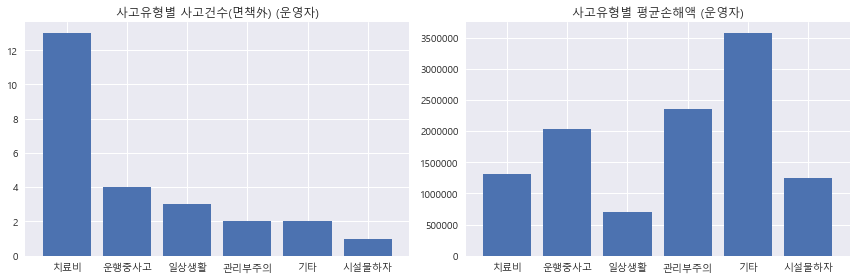

In [45]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].bar(통계_사고유형별_카카오_운영자['사고유형2'], 통계_사고유형별_카카오_운영자['사고건수'])
ax[0].set_title('사고유형별 사고건수(면책外) (운영자)')

ax[1].bar(통계_사고유형별_카카오_운영자['사고유형2'], 통계_사고유형별_카카오_운영자['평균손해액'])
ax[1].set_title('사고유형별 평균손해액 (운영자)')
plt.tight_layout()
plt.savefig('img/사고유형_운영자.png')
plt.show()

In [8]:
사고이력_카카오_운영자_유효 = 사고이력_카카오_운영자_가공.query('사고년월 <= "202001"').query('손해액 > 0')
사고건수_사고유형별_카카오_운영자 = 사고이력_카카오_운영자_유효.groupby('사고유형2').size().reset_index(name='사고건수').sort_values(by='사고건수', ascending=False)
평균손해액_사고유형별_카카오_운영자 = 사고이력_카카오_운영자_유효.groupby('사고유형2')['손해액'].mean().reset_index(name='평균손해액').sort_values(by='평균손해액', ascending=False)
총손해액_사고유형별_카카오_운영자 = 사고이력_카카오_운영자_유효.groupby('사고유형2')['손해액'].sum().astype(float).reset_index(name='총손해액').sort_values(by='총손해액', ascending=False)
통계_사고유형별_카카오_운영자 = 사고건수_사고유형별_카카오_운영자.merge(평균손해액_사고유형별_카카오_운영자, on='사고유형2', how='outer').merge(총손해액_사고유형별_카카오_운영자, on='사고유형2', how='outer')
통계_사고유형별_카카오_운영자

,사고유형2,사고건수,평균손해액,총손해액
0,치료비,13,"1,318,024","17,134,316"
1,운행중사고,4,"2,037,500","8,150,000"
2,일상생활,3,"704,972","2,114,915"
3,관리부주의,2,"2,362,000","4,724,000"
4,기타,2,"3,573,800","7,147,600"
5,시설물하자,1,"1,243,700","1,243,700"


parameter : (0.597987958211139, 0, 2710056.645367767)
gamma     - parameter: (0.597987958211139, 0, 2710056.645367767), loglik: -379.74, AIC: 763.48, BIC: 765.91


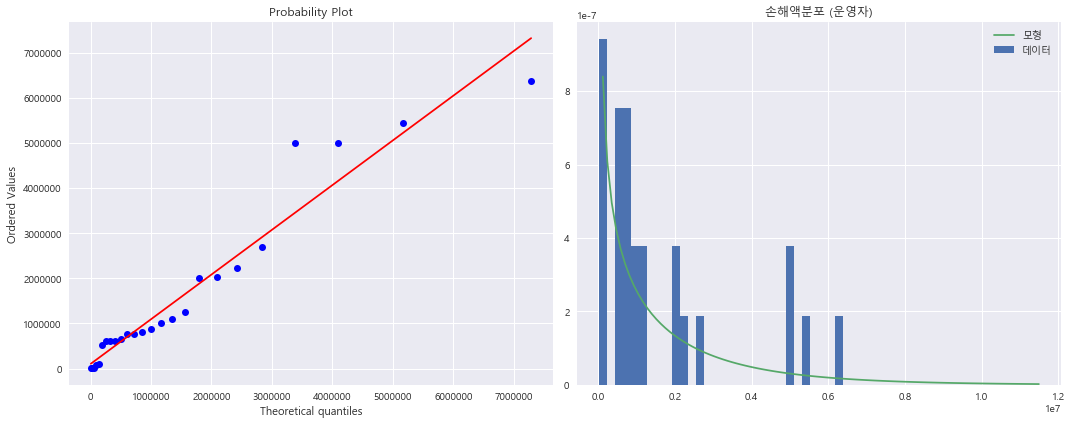

In [63]:
# dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
손해액_카카오_운영자 = 사고이력_카카오_운영자_유효['손해액'].astype(float).values

dist_names = ['gamma']
모수추정_손해액_카카오_운영자 = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(손해액_카카오_운영자, floc=0)
    손해액난수_카카오_운영자 = dist(*param[:-2], loc=param[-2], scale=param[-1])
    loglik = np.sum(np.log(손해액난수_카카오_운영자.pdf(손해액_카카오_운영자)))
    k = len(param)-1
    n = len(손해액_카카오_운영자)
    aic = -2*loglik + 2*k
    bic = -2*loglik + k*np.log(n)
    모수추정_손해액_카카오_운영자.append([dist_name, loglik, aic, bic, param])
    print('parameter : {}'.format(param))
    print('{:9} - parameter: {}, loglik: {:,.2f}, AIC: {:,.2f}, BIC: {:,.2f}'.format(dist_name, param, loglik, aic, bic))
모수추정_손해액_카카오_운영자 = pd.DataFrame(모수추정_손해액_카카오_운영자, columns=['name', 'loglik', 'aic', 'bic', 'param']).sort_values(by='loglik', ascending=False)

fig, ax = plt.subplots(1,2, figsize=(15,6))
scipy.stats.probplot(손해액_카카오_운영자, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[0])
x = np.linspace(0, 손해액난수_카카오_운영자.ppf(0.995), 100)
y = 손해액난수_카카오_운영자.pdf(x)
ax[1].hist(손해액_카카오_운영자, density=True, bins=30, label='데이터')
ax[1].plot(x, y, label='모형')
ax[1].legend()
ax[1].set_title('손해액분포 (운영자)')
plt.tight_layout()
plt.savefig('img/손해액분포_운영자.png')
plt.show()

#### Ⅳ. 지급지연(운영자)

parameter : (2.36897775175707, 0, 26.91993507555192)
gamma     - parameter: (2.36897775175707, 0, 26.91993507555192), loglik: -109.71, AIC: 223.43, BIC: 225.61


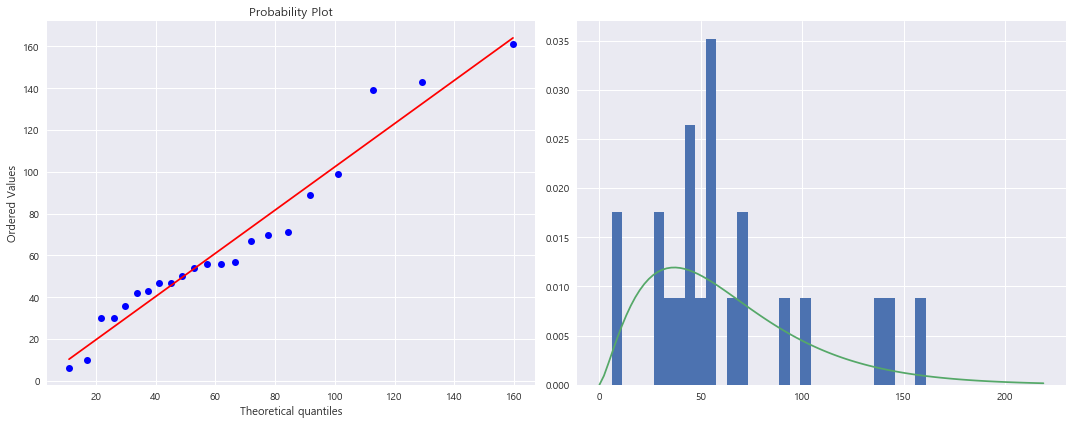

In [10]:
지급지연_카카오_운영자 = (사고이력_카카오_운영자_유효['지급일자']-사고이력_카카오_운영자_유효['사고일']).dropna().apply(lambda x:x.days).astype(float).values

dist_names = ['gamma']
모수추정_지급지연_카카오_운영자 = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(지급지연_카카오_운영자, floc=0)
    지급지연난수_카카오_운영자 = dist(*param[:-2], loc=param[-2], scale=param[-1])
    loglik = np.sum(np.log(지급지연난수_카카오_운영자.pdf(지급지연_카카오_운영자)))
    k = len(param)-1
    n = len(지급지연_카카오_운영자)
    aic = -2*loglik + 2*k
    bic = -2*loglik + k*np.log(n)
    모수추정_지급지연_카카오_운영자.append([dist_name, loglik, aic, bic, param])
    print('parameter : {}'.format(param))
    print('{:9} - parameter: {}, loglik: {:,.2f}, AIC: {:,.2f}, BIC: {:,.2f}'.format(dist_name, param, loglik, aic, bic))
모수추정_지급지연_카카오_운영자 = pd.DataFrame(모수추정_지급지연_카카오_운영자, columns=['name', 'loglik', 'aic', 'bic', 'param']).sort_values(by='loglik', ascending=False)

fig, ax = plt.subplots(1,2, figsize=(15,6))
scipy.stats.probplot(지급지연_카카오_운영자, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[0])
x = np.linspace(0, 지급지연난수_카카오_운영자.ppf(0.995), 100)
y = 지급지연난수_카카오_운영자.pdf(x)
ax[1].hist(지급지연_카카오_운영자, density=True, bins=30)
ax[1].plot(x, y)
plt.tight_layout()
plt.savefig('img/지급지연_분포_운영자.png')
plt.show()

#### Ⅴ. 사고건수(이용자)

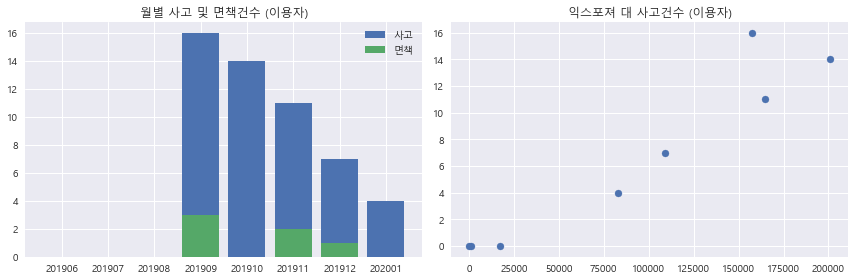

In [60]:
사고이력_카카오_이용자_가공 = 사고이력_카카오_이용자.copy()
사고이력_카카오_이용자_가공.eval('손해액 = 추산잔액+지급액+지급비용', inplace=True)
사고이력_카카오_이용자_가공['사고년월'] = 사고이력_카카오_이용자_가공['사고일'].apply(lambda x: str(x.year) + '{:02}'.format(x.month))
사고건수_카카오_이용자 = 사고이력_카카오_이용자_가공.groupby('사고년월').size().reset_index(name='사고건수')
면책건수_카카오_이용자 = 사고이력_카카오_이용자_가공.query('손해액 == 0').groupby('사고년월').size().reset_index(name='면책건수')
사고및면책_카카오_이용자 = 사고건수_카카오_이용자.merge(면책건수_카카오_이용자, on='사고년월', how='outer')
사고및면책_카카오_이용자[['사고건수', '면책건수']] = 사고및면책_카카오_이용자[['사고건수', '면책건수']].fillna(0)
사고및면책_카카오_이용자 = 익스포져_카카오_가공.merge(사고및면책_카카오_이용자, left_on='기준년월', right_on='사고년월', how='outer')
사고및면책_카카오_이용자 = 사고및면책_카카오_이용자.query('기준년월 <= "202001"').drop('사고년월', axis=1)
총손해액_카카오_이용자 = 사고이력_카카오_이용자_가공.groupby('사고년월')['손해액'].sum().astype(float).reset_index(name='총손해액')
사고및면책_카카오_이용자 = 사고및면책_카카오_이용자.merge(총손해액_카카오_이용자, left_on='기준년월', right_on='사고년월', how='outer')
사고및면책_카카오_이용자 = 사고및면책_카카오_이용자.query('기준년월 <= "202001"').drop('사고년월', axis=1)
사고및면책_카카오_이용자.eval('평균손해액 = 총손해액/(사고건수-면책건수)', inplace=True)
사고및면책_카카오_이용자[['사고건수','면책건수','총손해액','평균손해액']] = 사고및면책_카카오_이용자[['사고건수','면책건수','총손해액','평균손해액']].fillna(0)

익스포져_사고건수_상관관계_카카오_이용자 = 사고및면책_카카오_이용자[['운행건수', '사고건수']].corr()*100

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].bar(사고및면책_카카오_이용자['기준년월'], 사고및면책_카카오_이용자['사고건수'], label='사고')
ax[0].bar(사고및면책_카카오_이용자['기준년월'], 사고및면책_카카오_이용자['면책건수'], label='면책')
ax[0].set_title('월별 사고 및 면책건수 (이용자)')
ax[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax[0].legend()

ax[1].scatter(사고및면책_카카오_이용자['운행건수'], 사고및면책_카카오_이용자['사고건수'])
ax[1].set_title('익스포져 대 사고건수 (이용자)')
plt.tight_layout()
plt.savefig('img/사고건수_이용자.png')
plt.show()

In [12]:
사고및면책_카카오_이용자

,기준년월,시작일자,종료일자,운행건수,경과일자,사고건수,면책건수,총손해액,평균손해액
0,201906,2019-06-19,2019-06-30,200,11,0,0,0,0
1,201907,2019-07-01,2019-07-31,900,30,0,0,0,0
2,201908,2019-08-01,2019-08-31,"17,038",30,0,0,0,0
3,201909,2019-09-01,2019-09-30,"157,620",29,16,3,"27,860,743","2,143,134"
4,201910,2019-10-01,2019-10-31,"200,980",30,14,0,"8,419,937","601,424"
5,201911,2019-11-01,2019-11-30,"164,840",29,11,2,"11,824,940","1,313,882"
6,201912,2019-12-01,2019-12-31,"108,861",30,7,1,"6,904,180","1,150,697"
7,202001,2020-01-01,2020-01-31,"82,953",30,4,0,"6,372,370","1,593,092"


In [13]:
익스포져_사고건수_상관관계_카카오_이용자

,운행건수,사고건수
운행건수,100,95
사고건수,95,100


In [14]:
운행건_일별_카카오_이용자 = 사고및면책_카카오_이용자['운행건수'].sum()/사고및면책_카카오_이용자['경과일자'].sum()
사고율_카카오_이용자 = 사고및면책_카카오_이용자['사고건수'].sum()/사고및면책_카카오_이용자['운행건수'].sum()
면책율_카카오_이용자 = 사고및면책_카카오_이용자['면책건수'].sum()/사고및면책_카카오_이용자['사고건수'].sum()
평균손해액_카카오_이용자 = 사고및면책_카카오_이용자['총손해액'].sum()/(사고및면책_카카오_이용자['사고건수'].sum()-사고및면책_카카오_이용자['면책건수'].sum())
print(사고및면책_카카오_이용자[['경과일자', '운행건수', '사고건수', '면책건수', '총손해액']].sum(axis=0))
print('-'*30)
print('운행건수(일별): {:,.0f}건'.format(운행건_일별_카카오_이용자))
print('사고율(운행당): {:,.4f}%'.format(사고율_카카오_이용자*100))
print('면책율(사고당): {:,.2f}%'.format(면책율_카카오_이용자*100))
print('평균손해액(사고당): {:,.0f}원'.format(평균손해액_카카오_이용자))

경과일자          219
운행건수      733,392
사고건수           52
면책건수            6
총손해액   61,382,170
dtype: float64
------------------------------
운행건수(일별): 3,349건
사고율(운행당): 0.0071%
면책율(사고당): 11.54%
평균손해액(사고당): 1,334,395원


#### Ⅵ. 사고심도(이용자)

In [15]:
사고이력_카카오_이용자_유효 = 사고이력_카카오_이용자_가공.query('사고년월 <= "202001"').query('손해액 > 0')
사고건수_사고유형별_카카오_이용자 = 사고이력_카카오_이용자_유효.groupby('사고유형2').size().reset_index(name='사고건수').sort_values(by='사고건수', ascending=False)
평균손해액_사고유형별_카카오_이용자 = 사고이력_카카오_이용자_유효.groupby('사고유형2')['손해액'].mean().reset_index(name='평균손해액').sort_values(by='평균손해액', ascending=False)
총손해액_사고유형별_카카오_이용자 = 사고이력_카카오_이용자_유효.groupby('사고유형2')['손해액'].sum().astype(float).reset_index(name='총손해액').sort_values(by='총손해액', ascending=False)
통계_사고유형별_카카오_이용자 = 사고건수_사고유형별_카카오_이용자.merge(평균손해액_사고유형별_카카오_이용자, on='사고유형2', how='outer').merge(총손해액_사고유형별_카카오_이용자, on='사고유형2', how='outer')
통계_사고유형별_카카오_이용자

,사고유형2,사고건수,평균손해액,총손해액
0,일상생활,37,"1,179,999","43,659,956"
1,운행중사고,6,"1,217,952","7,307,714"
2,기타,1,"8,409,500","8,409,500"
3,치료비,1,"5,000","5,000"
4,파손,1,"2,000,000","2,000,000"


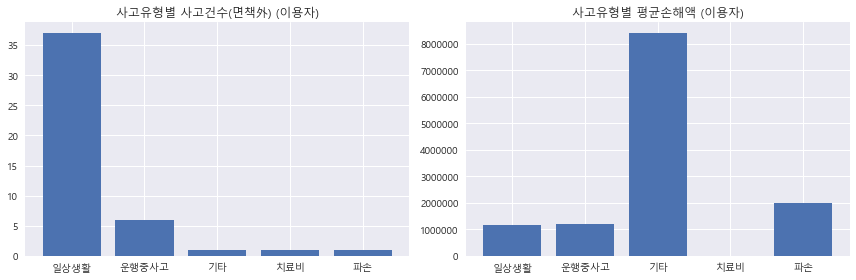

In [46]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].bar(통계_사고유형별_카카오_이용자['사고유형2'], 통계_사고유형별_카카오_이용자['사고건수'])
ax[0].set_title('사고유형별 사고건수(면책外) (이용자)')

ax[1].bar(통계_사고유형별_카카오_이용자['사고유형2'], 통계_사고유형별_카카오_이용자['평균손해액'])
ax[1].set_title('사고유형별 평균손해액 (이용자)')
plt.tight_layout()
plt.savefig('img/사고유형_이용자.png')
plt.show()

parameter : (0.804850121497442, 0, 1657942.2234755058)
gamma     - parameter: (0.804850121497442, 0, 1657942.2234755058), loglik: -694.01, AIC: 1,392.02, BIC: 1,395.68


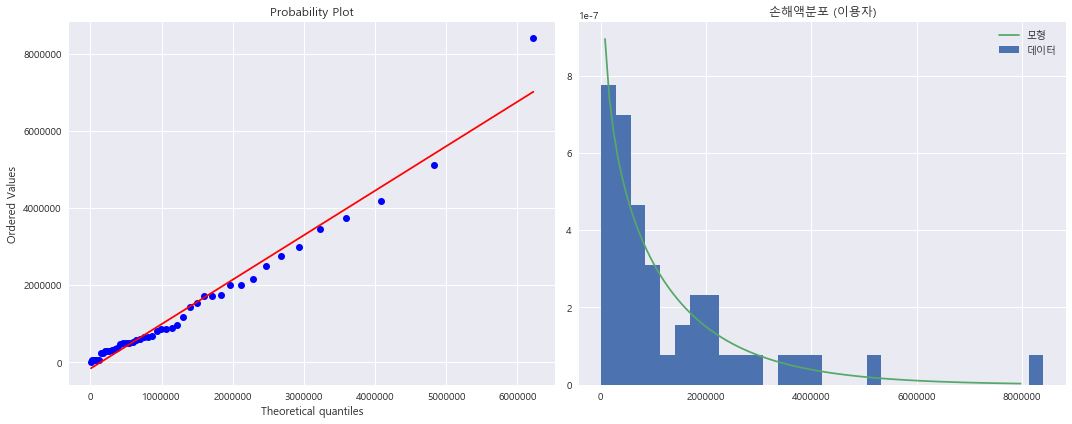

In [62]:
손해액_카카오_이용자 = 사고이력_카카오_이용자_유효['손해액'].astype(float).values

dist_names = ['gamma']
모수추정_손해액_카카오_이용자 = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(손해액_카카오_이용자, floc=0)
    손해액난수_카카오_이용자 = dist(*param[:-2], loc=param[-2], scale=param[-1])
    loglik = np.sum(np.log(손해액난수_카카오_이용자.pdf(손해액_카카오_이용자)))
    k = len(param)-1
    n = len(손해액_카카오_이용자)
    aic = -2*loglik + 2*k
    bic = -2*loglik + k*np.log(n)
    모수추정_손해액_카카오_이용자.append([dist_name, loglik, aic, bic, param])
    print('parameter : {}'.format(param))
    print('{:9} - parameter: {}, loglik: {:,.2f}, AIC: {:,.2f}, BIC: {:,.2f}'.format(dist_name, param, loglik, aic, bic))
모수추정_손해액_카카오_이용자 = pd.DataFrame(모수추정_손해액_카카오_이용자, columns=['name', 'loglik', 'aic', 'bic', 'param']).sort_values(by='loglik', ascending=False)

fig, ax = plt.subplots(1,2, figsize=(15,6))
scipy.stats.probplot(손해액_카카오_이용자, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[0])
x = np.linspace(0, 손해액난수_카카오_이용자.ppf(0.995), 100)
y = 손해액난수_카카오_이용자.pdf(x)
ax[1].hist(손해액_카카오_이용자, density=True, bins=30, label='데이터')
ax[1].plot(x, y, label='모형')
ax[1].legend()
ax[1].set_title('손해액분포 (이용자)')
plt.tight_layout()
plt.savefig('img/손해액분포_이용자.png')
plt.show()

#### Ⅶ. 지급지연(이용자)

parameter : (1.7904322793597536, 0, 20.665400432364272)
gamma     - parameter: (1.7904322793597536, 0, 20.665400432364272), loglik: -181.02, AIC: 366.04, BIC: 369.41


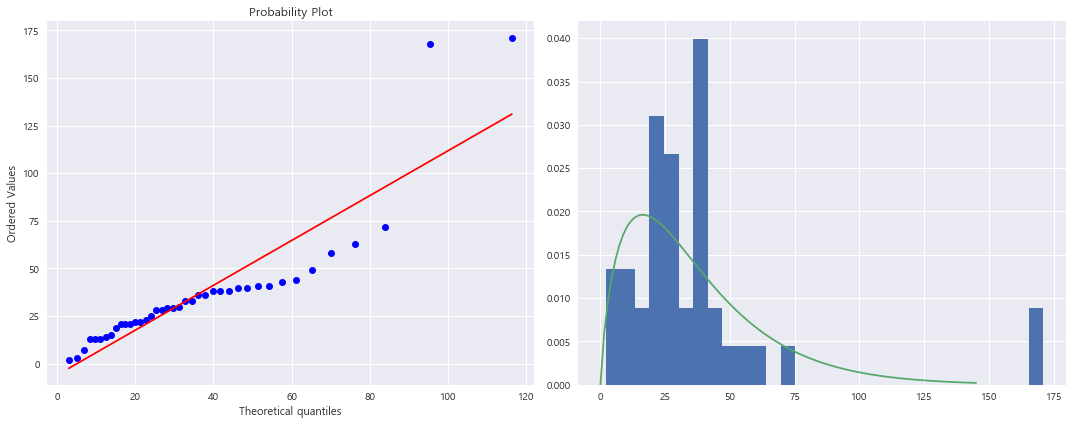

In [17]:
지급지연_카카오_이용자 = (사고이력_카카오_이용자_유효['지급일자']-사고이력_카카오_이용자_유효['사고일']).dropna().apply(lambda x:x.days).astype(float).values

dist_names = ['gamma']
모수추정_지급지연_카카오_이용자 = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(지급지연_카카오_이용자, floc=0)
    지급지연난수_카카오_이용자 = dist(*param[:-2], loc=param[-2], scale=param[-1])
    loglik = np.sum(np.log(지급지연난수_카카오_이용자.pdf(지급지연_카카오_이용자)))
    k = len(param)-1
    n = len(지급지연_카카오_이용자)
    aic = -2*loglik + 2*k
    bic = -2*loglik + k*np.log(n)
    모수추정_지급지연_카카오_이용자.append([dist_name, loglik, aic, bic, param])
    print('parameter : {}'.format(param))
    print('{:9} - parameter: {}, loglik: {:,.2f}, AIC: {:,.2f}, BIC: {:,.2f}'.format(dist_name, param, loglik, aic, bic))
모수추정_지급지연_카카오_이용자 = pd.DataFrame(모수추정_지급지연_카카오_이용자, columns=['name', 'loglik', 'aic', 'bic', 'param']).sort_values(by='loglik', ascending=False)

fig, ax = plt.subplots(1,2, figsize=(15,6))
scipy.stats.probplot(지급지연_카카오_이용자, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[0])
x = np.linspace(0, 지급지연난수_카카오_이용자.ppf(0.995), 100)
y = 지급지연난수_카카오_이용자.pdf(x)
ax[1].hist(지급지연_카카오_이용자, density=True, bins=30)
ax[1].plot(x, y)
plt.tight_layout()
plt.savefig('img/지급지연_이용자.png')
plt.show()

#### Ⅷ. 시뮬레이션

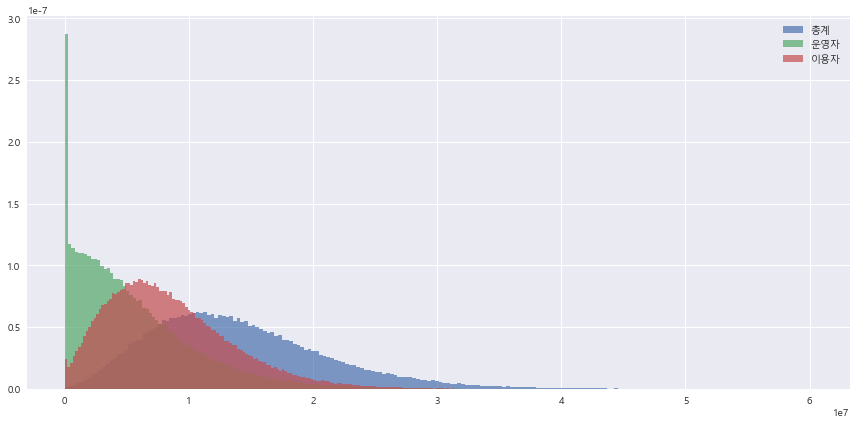

In [18]:
# 예치보험료_카카오_운영자 = 17500000
# 예치보험료_카카오_이용자 = 17500000

사고빈도_카카오_운영자 = 운행건_일별_카카오_운영자*30*사고율_카카오_운영자*(1-면책율_카카오_운영자)
사고빈도_카카오_이용자 = 운행건_일별_카카오_이용자*30*사고율_카카오_이용자*(1-면책율_카카오_이용자)

dist = getattr(scipy.stats, 'poisson')
사고건수난수_카카오_운영자 = dist(사고빈도_카카오_운영자)
사고건수난수_카카오_이용자 = dist(사고빈도_카카오_이용자)

난수 = 200000
단위 = 1e0
np.random.seed(1)
총손해액시뮬레이션_카카오_운영자 = np.array([손해액난수_카카오_운영자.rvs(n).sum() for n in 사고건수난수_카카오_운영자.rvs(난수)])
총손해액시뮬레이션_카카오_이용자 = np.array([손해액난수_카카오_이용자.rvs(m).sum() for m in 사고건수난수_카카오_이용자.rvs(난수)])
총손해액시뮬레이션_카카오 = 총손해액시뮬레이션_카카오_운영자+총손해액시뮬레이션_카카오_이용자
총손해액시뮬레이션_집계 = pd.DataFrame(np.c_[총손해액시뮬레이션_카카오_운영자, 총손해액시뮬레이션_카카오_이용자, 총손해액시뮬레이션_카카오], columns=['운영자', '이용자', '전체'])

plt.figure(figsize=(12,6))
plt.hist(총손해액시뮬레이션_카카오/단위, bins=200, alpha=0.7, label='총계', density=True)
plt.hist(총손해액시뮬레이션_카카오_운영자/단위, bins=200, alpha=0.7, label='운영자', density=True)
plt.hist(총손해액시뮬레이션_카카오_이용자/단위, bins=200, alpha=0.7, label='이용자', density=True)
plt.legend()
plt.tight_layout()
plt.savefig('img/총손해액시뮬레이션.png')
plt.show()

In [19]:
q = 70.0
p = 99.5

카카오_이용자_보험료_건당 = 60
카카오_운영자_보험료_건당 = 60
카카오_보험료_건당 = 카카오_이용자_보험료_건당+카카오_운영자_보험료_건당

카카오_이용자_보험료 = 운행건_일별_카카오_이용자*30*카카오_이용자_보험료_건당
카카오_운영자_보험료 = 운행건_일별_카카오_운영자*30*카카오_운영자_보험료_건당
카카오_보험료 = 카카오_이용자_보험료+카카오_운영자_보험료

카카오_이용자_손실확률 = sum(총손해액시뮬레이션_카카오_이용자>카카오_이용자_보험료)/len(총손해액시뮬레이션_카카오_이용자)
카카오_운영자_손실확률 = sum(총손해액시뮬레이션_카카오_운영자>카카오_운영자_보험료)/len(총손해액시뮬레이션_카카오_운영자)
카카오_손실확률 = sum(총손해액시뮬레이션_카카오>카카오_보험료)/len(총손해액시뮬레이션_카카오)

보험료_건당 = np.array([카카오_이용자_보험료_건당, 카카오_운영자_보험료_건당, 카카오_보험료_건당])
보험료 = np.array([카카오_이용자_보험료, 카카오_운영자_보험료, 카카오_보험료])
손해액_평균 = np.array([총손해액시뮬레이션_카카오_이용자.mean(), 총손해액시뮬레이션_카카오_운영자.mean(), 총손해액시뮬레이션_카카오.mean()])
손해액_표준편차 = np.array([총손해액시뮬레이션_카카오_이용자.std(), 총손해액시뮬레이션_카카오_운영자.std(), 총손해액시뮬레이션_카카오.std()])
손해액_VaR_70 = np.array([np.percentile(총손해액시뮬레이션_카카오_이용자, q), np.percentile(총손해액시뮬레이션_카카오_운영자, q), np.percentile(총손해액시뮬레이션_카카오, q)])
손해액_VaR = np.array([np.percentile(총손해액시뮬레이션_카카오_이용자, p), np.percentile(총손해액시뮬레이션_카카오_운영자, p), np.percentile(총손해액시뮬레이션_카카오, p)])
손해율_평균 = 손해액_평균/보험료*100
손해율_표준편차 = 손해액_표준편차/보험료*100
손해율_VaR_70 = 손해액_VaR_70/보험료*100
손해율_VaR = 손해액_VaR/보험료*100
손실확률 = np.array([카카오_이용자_손실확률, 카카오_운영자_손실확률, 카카오_손실확률])*100

시뮬레이션결과 = pd.DataFrame([보험료_건당, 보험료, 손해액_평균, 손해액_표준편차, 손해액_VaR_70, 손해액_VaR, 손해율_평균, 손해율_표준편차, 손해율_VaR_70, 손해율_VaR, 손실확률],
                    columns=['이용자', '운영자', '전체'],
                    index=['보험료_건당', '보험료', '손해액_평균', '손해액_표준편차', '손해액_VaR({:.1f}%)'.format(q), '손해액_VaR({:.1f}%)'.format(p), '손해율_평균', '손해율_표준편차', '손해율_VaR({:.1f}%)'.format(q), '손해율_VaR({:.1f}%)'.format(p), '손실확률'])
시뮬레이션결과

,이용자,운영자,전체
보험료_건당,60,60,120
보험료,"6,027,879","6,027,879","12,055,759"
손해액_평균,"8,418,875","5,555,861","13,974,736"
손해액_표준편차,"5,021,145","4,922,071","7,036,756"
손해액_VaR(70.0%),"10,412,885","7,063,195","16,844,877"
손해액_VaR(99.5%),"25,466,557","24,309,532","37,495,959"
손해율_평균,140,92,116
손해율_표준편차,83,82,58
손해율_VaR(70.0%),173,117,140
손해율_VaR(99.5%),422,403,311


In [56]:
now = datetime.now().strftime('%Y%m%d%H%M%S')
with pd.ExcelWriter('result/카카오_모빌리티_{}.xlsx'.format(now)) as writer:
    사고및면책_카카오_운영자.to_excel(writer, '사고및면책_카카오_운영자', index=False)
    익스포져_사고건수_상관관계_카카오_운영자.to_excel(writer, '익스포져_사고건수_상관관계_카카오_운영자', index=False)
    통계_사고유형별_카카오_운영자.to_excel(writer, '통계_사고유형별_카카오_운영자', index=False)
    모수추정_손해액_카카오_운영자.to_excel(writer, '모수추정_카카오_운영자', index=False)
    모수추정_지급지연_카카오_운영자.to_excel(writer, '모수추정_지급지연_카카오_운영자', index=False)
    사고이력_카카오_운영자_가공.sort_values(by='손해액', ascending=False).head(5).to_excel(writer, '상위5개사고_카카오_운영자', index=False)
    
    사고및면책_카카오_이용자.to_excel(writer, '사고및면책_카카오_이용자', index=False)
    익스포져_사고건수_상관관계_카카오_이용자.to_excel(writer, '익스포져_사고건수_상관관계_카카오_이용자', index=False)
    통계_사고유형별_카카오_이용자.to_excel(writer, '통계_사고유형별_카카오_이용자', index=False)
    모수추정_손해액_카카오_이용자.to_excel(writer, '모수추정_카카오_이용자', index=False)
    모수추정_지급지연_카카오_이용자.to_excel(writer, '모수추정_지급지연_카카오_이용자', index=False)
    사고이력_카카오_이용자_가공.sort_values(by='손해액', ascending=False).head(5).to_excel(writer, '상위5개사고_카카오_이용자', index=False)
    
    시뮬레이션결과.to_excel(writer, '시뮬레이션결과', index=True)

In [59]:
with pd.ExcelWriter('result/카카오_모빌리티_시뮬레이션_{}.xlsx'.format(now)) as writer:
    총손해액시뮬레이션_집계.to_excel(writer, '총손해액시뮬레이션_집계', index=False)